# Challenge: Quantum Natural Language Processing with lambeq

## Womanium Quantum Hackathon 2022

## 0. Basic Information

- **Team Name**: QThinkers
- **Member & Contributions**:
    - **Henry Zhiyu Ma (presenter)**: Coding & Writing this notebook (95%)
    - Dimple Mevada: Discussion on algorithms (5%)
    - Isabel Huh: None (0%)
    - Constantin Drabo: None (0%)\
- **Contact Information**:
    - Mr. Henry Zhiyu Ma: [Email](mailto:henry.zhiyu.ma@gmail.com), [GitHub](https://github.com/YujiUgaki), [LinkedIn](https://www.linkedin.com/in/henry-z-ma/)

## 1. Summary

This project aims at implementing **quantum algorithms** for **natural language processing (NLP)**, specifically, to determine whether a pair of short sentences belong to the same topic.

Although a similar algorithm has been developed [1](https://cqcl.github.io/lambeq/tutorials/trainer_quantum.html), it only deals with one sentence each time. Therefore, we followed its quantum training pipeline while customizing the original `NumpyModel` to adapt it to sentence pair processing. We rewrite the `forward` method, adding the following features to it:
  - accept **two lists** of circuits as input
  - calculate the **cosine value** [2](https://arxiv.org/abs/1910.09129) of the feature vectors for each sentence in a pair
With this custom method, we have successfully trained the model.

Future improvements:
  - New reading and parsing methods
  - New similarity metrics for better performance
  - Creating circuits using different prameters of ansatz
  - Running these codes on AerBackend or even a real quantum computer

## 2. Codes

### Step 0: preparation

Preparing & importing packages

In [ ]:
!pip install sklearn

In [ ]:
!pip install lambeq

In [3]:
import os
import sklearn
import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from lambeq import BobcatParser, AtomicType, IQPAnsatz, remove_cups, NumpyModel, QuantumTrainer, SPSAOptimizer, Dataset

warnings.filterwarnings('ignore')


/home/jovyan/.qbraid/environments/womanium_go14xk/pyenv/lib/python3.9/site-packages/lambeq/text2diagram/ccg_parser.py:24: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Defining parameter for training

In [4]:
BATCH_SIZE = 30 # batch size
EPOCHS = 1000 # number of iterations
SEED = 2
eps = 1e-6 # a small number to get rid of 'NaN' value in 'log' function of binary cross-entropy loss

### Step 1: importing data

Importing the dataset

In [5]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            
            # extract & append labels
            t = float(line[-2])
            labels.append(t)
            
            # extract and sentences (Sentence 0 & 1 as a whole)
            sentences.append(line[:-4])
            
    return labels, sentences

# input data
# MC1.txt is in the same folder as this jupyter notebook
train_test_labels, train_test_data = read_data('./MC1.txt')

Randomly splitting the whole dataset into **train set (0.8)** and **test set (0.2)**, using `sklearn.model_selection import train_test_split`

In [6]:
train_data, test_data, train_labels, test_labels = train_test_split(train_test_data, train_test_labels, test_size=0.2, random_state=66)

Splitting the 2 sentences in each line apart

In [7]:
def split_data(data):
    data0, data1 = [], []
    for sentence in data:
        data0.append(sentence.split(', ')[0])
        data1.append(sentence.split(', ')[1])
    return data0, data1

train_data0, train_data1 = split_data(train_data)
test_data0, test_data1 = split_data(test_data)

### Step 2: creating, filtering, and simplifying diagrams

**Parsing** sentences with `BobcatParser`

In [8]:
parser = BobcatParser(root_cats=('NP', 'N'), verbose='text')

Converting each sentence to **diagrams**

In [9]:
raw_train_diagrams0 = parser.sentences2diagrams(train_data0, suppress_exceptions=True) # the 0th sentences in train set
raw_train_diagrams1 = parser.sentences2diagrams(train_data1, suppress_exceptions=True) # the 1st sentences in train set
raw_test_diagrams0 = parser.sentences2diagrams(test_data0, suppress_exceptions=True) # the 0th sentences in test set
raw_test_diagrams1 = parser.sentences2diagrams(test_data1, suppress_exceptions=True) # the 1st sentences in test set

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


Transforming diagrams to **normal forms**, simultaneously eliminating empty diagrams

In [10]:
train_diagrams0 = [
    diagram.normal_form()
    for diagram in raw_train_diagrams0 if diagram is not None
]
train_diagrams1 = [
    diagram.normal_form()
    for diagram in raw_train_diagrams1 if diagram is not None
]
test_diagrams0 = [
    diagram.normal_form()
    for diagram in raw_test_diagrams0 if diagram is not None
]
test_diagrams1 = [
    diagram.normal_form()
    for diagram in raw_test_diagrams1 if diagram is not None
]

Deleting the labels corresponsing to empty diagrams

In [11]:
train_labels = [
    label for (diagram0, diagram1, label)
    in zip(raw_train_diagrams0, raw_train_diagrams1, train_labels)
    if diagram0 is not None and diagram1 is not None]
test_labels = [
    label for (diagram0, diagram1, label)
    in zip(raw_test_diagrams0, raw_test_diagrams1, test_labels)
    if diagram0 is not None and diagram1 is not None]

### Step 3: creating circuits

Defining **ansatz**

In [12]:
ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 0},
                   n_layers=1, n_single_qubit_params=3)

**Removing the cups** of the diagrams to boost efficiency.

Converting diagrams to **circuits**.

In [13]:
train_circuits0 = [ansatz(remove_cups(diagram)) for diagram in train_diagrams0]
train_circuits1 = [ansatz(remove_cups(diagram)) for diagram in train_diagrams1]
test_circuits0 =  [ansatz(remove_cups(diagram))  for diagram in test_diagrams0]
test_circuits1 =  [ansatz(remove_cups(diagram))  for diagram in test_diagrams1]

### Step 4: defining custom model and evaluation metrics

Defining a custom **subclass** `MyCustomModel` from `NumpyModel` with a modified `forward` method

The `forward` method evaluates the **cosine** value of the **feature vectors** (outputs) of each sentence in a pair

In [14]:
class MyCustomModel(NumpyModel):
    def _init_(self):
        super()._init_()
    
    def forward(self,input):
        """This forward pass method has been customized for 2-sentence comparison
        
        Parameters
        ----------
        input : 2-dimensional list of :py:class:`Circuits <discopy.quantum.circuit.Circuit>` object
                I.e., a list of 2-circuit pairs of sentences
                The 0th dimension = BATCH_SIZE
                The 1st dimension = 2
        
        Returns
        -------
        numpy.ndarray
            Array containing model's prediction (y_hat)
            
        """
        
        # getting a 1-dimensional list of circuits for sentences0 & sentences1 from input
        # since self.get_diagram_output(x) only accepts 1-dimensional list x
        input0 = [input[i][0] for i in range(len(input))]
        input1 = [input[i][1] for i in range(len(input))]
        
        # evaluating feature vectors for sentences0 & sentences1
        preds0 = self.get_diagram_output(input0) # a list of 2-dimensional vectors [_,_]
        preds1 = self.get_diagram_output(input1)
        if len(preds0) != len(preds1):
            raise ValueError('Lengths of `preds0` and `preds1` differ.')
        
        # evaluating the cosine of the angle between the feature vectors for sentences0 & sentences1
        # supposing that cosine value measures similarity
        # ref: arXiv:1910.09129
        def vcos(v0, v1):
            return np.divide(np.dot(v0, v1), np.sqrt(np.multiply(np.dot(v0,v0), np.dot(v1,v1))))
        
        # list of cosine values for each pair of sentences
        coss = [vcos(preds0[i], preds1[i]) for i in range(len(preds0))]
        
        # converting cosine list to array
        preds = np.array(coss)
        return preds
    
    

Building model: `model.symbols` is generated from all words present in all sentences.

In [15]:
all_circuits = train_circuits0 + test_circuits0 + train_circuits1 + test_circuits1

# use jit to accelerate training
model = MyCustomModel.from_diagrams(all_circuits, use_jit=True)

Defining **loss** and **accuracy** function

In [16]:
loss = lambda y_hat, y: -np.sum(y * np.log(y_hat + eps)) / len(y)  # binary cross-entropy loss

acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting
etest_metrics = {"acc": acc}

### Step 5: initializing trainer and training

Setting up **trainer**

In [17]:
trainer = QuantumTrainer(
    model,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions=etest_metrics,
    evaluate_on_train=True,
    verbose = 'text',
    seed=SEED
)

Obtaining **datasets**

In [18]:
# list of circuit-pairs
train_circuits = [list(item) for item in zip(train_circuits0, train_circuits1)]
test_circuits = [list(item) for item in zip(test_circuits0, test_circuits1)]

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

test_dataset = Dataset(test_circuits, test_labels, shuffle=False)

**Fitting**

In [19]:
trainer.fit(train_dataset, test_dataset, evaluation_step=1, logging_step=100)

Epoch 1:     train/loss: 0.0707   valid/loss: 0.0907   train/acc: 0.2562   valid/acc: 0.3250
Epoch 100:   train/loss: 0.0236   valid/loss: 0.0333   train/acc: 0.2562   valid/acc: 0.3000
Epoch 200:   train/loss: 0.0201   valid/loss: 0.0292   train/acc: 0.2562   valid/acc: 0.3000
Epoch 300:   train/loss: 0.0183   valid/loss: 0.0270   train/acc: 0.2562   valid/acc: 0.3000
Epoch 400:   train/loss: 0.0173   valid/loss: 0.0260   train/acc: 0.2562   valid/acc: 0.3000
Epoch 500:   train/loss: 0.0155   valid/loss: 0.0248   train/acc: 0.2562   valid/acc: 0.3000
Epoch 600:   train/loss: 0.0136   valid/loss: 0.0242   train/acc: 0.2562   valid/acc: 0.3000
Epoch 700:   train/loss: 0.0144   valid/loss: 0.0234   train/acc: 0.2562   valid/acc: 0.3000
Epoch 800:   train/loss: 0.0132   valid/loss: 0.0228   train/acc: 0.2562   valid/acc: 0.3000
Epoch 900:   train/loss: 0.0150   valid/loss: 0.0218   train/acc: 0.2562   valid/acc: 0.3000
Epoch 1000:  train/loss: 0.0130   valid/loss: 0.0210   train/acc: 0.25

Plotting fitted results

Validation accuracy: 0.3


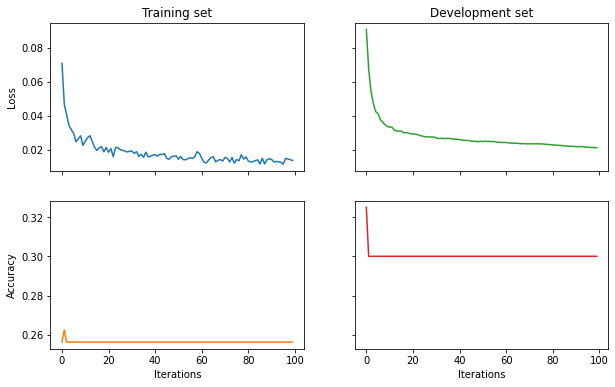

In [21]:
fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs[::10], color=next(colours))
ax_bl.plot(trainer.train_results['acc'][::10], color=next(colours))
ax_tr.plot(trainer.val_costs[::10], color=next(colours))
ax_br.plot(trainer.val_results['acc'][::10], color=next(colours))

# print test accuracy
test_acc = acc(model(test_circuits), test_labels)
print('Validation accuracy:', test_acc.item())